In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# ATLANTIC region

In [2]:
import xarray as xr
import os as os
import pandas as pd
import scipy.stats as stats
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.fft import fft, fftfreq
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

# Assuming you have already computed and stored your clusters in the 'clusters' variable

# Convert clusters to a list of arrays (one array per cluster)
from sklearn.metrics import silhouette_score, pairwise_distances
import minisom

def einlesen(area, nc):
    if area=="ATLANTIC":
        print("einlesen beginnt")
        #path_climatology = r"N:/atm_glomod/user/jomuel001/CMIP6_models_prec/"+model+"/prec_ERA5_1985-2014.N_mjjaso_remapbnds.nc"
        fig = plt.figure(figsize=(8, 8))

        map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        #nc_climatology = NetCDFFile(path_climatology)
        #print(nc)
        #nc
        lat = nc.variables['lat'][:54]
        lon = nc.variables['lon'][:]
        try:
            var=nc.variables['MSL'][:].astype(np.float32)
        except:
            var=nc.variables['psl'][:].astype(np.float32)
        reduced_lon = lon[:80]
        lon = np.concatenate((reduced_lon, lon[-80:]), axis=0)
        #time = nc.variables['time'][:]
        reduced_var = var[:, :54, :80]
        var = np.concatenate((reduced_var, var[:, :54, -80:]), axis=2)
        print("einlesen fertig")
        # Your data (var) and any preprocessing if needed
        data = var
        flattened_data = data.reshape(data.shape[0], -1)
        data_normalized = (flattened_data - flattened_data.min()) / (flattened_data.max() - flattened_data.min())
        return data_normalized, lon, lat, var
    elif area=="ARCTIC":
        print("einlesen beginnt")
        #path_climatology = r"N:/atm_glomod/user/jomuel001/CMIP6_models_prec/"+model+"/prec_ERA5_1985-2014.N_mjjaso_remapbnds.nc"
        fig = plt.figure(figsize=(8, 8))

        map = Basemap(projection='npstere', boundinglat=60, lon_0=0, llcrnrlon=0, urcrnrlon=360)
        #nc_climatology = NetCDFFile(path_climatology)
        #print(nc)
        #nc
        lat = nc.variables['lat'][:28]
        lon = nc.variables['lon'][:]
        var=nc.variables['MSL'][:].astype(np.float32)
        #reduced_lon = lon[:]
        #lon = np.concatenate((reduced_lon, lon[:]), axis=0)
        #time = nc.variables['time'][:]
        #reduced_var = var[:, :54, :]
        #var = np.concatenate((reduced_var, var[:, :28,:]), axis=2)
        print("einlesen fertig")
        # Your data (var) and any preprocessing if needed
        data = var
        flattened_data = data.reshape(data.shape[0], -1)
        data_normalized = (flattened_data - flattened_data.min()) / (flattened_data.max() - flattened_data.min())
        return data_normalized, lon, lat, var

        
        
def clustering(LR, SIGMA, THRESHOLD,NUM_ITER, AREA, data_normalized, lon, lat, var,a,b, n_init, PLOTTEN):
    area=AREA #ATLANTIC
    method="analysis" #analysis
    number_cluster_soms=a*b
    if area=="ATLANTIC":
        print("First Training taking place")
        # Initialize the SOM
        #num_iter = NUM_ITER
        lr = LR
        sigma = SIGMA
        def updated_lr(lr,epoch,num_iter):
            return lr
        def updated_sigma(sigma,epoch, num_iter):
            return sigma
        
        som = minisom.MiniSom(a, b, data_normalized.shape[1], sigma=sigma, learning_rate=lr, neighborhood_function="gaussian")
        
        # Initialize weights randomly
        for i in range(0,n_init,1):
            som.random_weights_init(data_normalized)
            num_iter = NUM_ITER
            som.train(data_normalized, num_iteration=num_iter)
            i+=1
                # Plot the losses
            # Training loop
        print(f"Number of epochs is {num_iter}")
        print("clustering findet statt")
        # Find the best-matching unit (BMU) for each data point
        cluster_centers = som.get_weights()
        bmus = np.array([som.winner(d) for d in data_normalized])

        # Create a dictionary to map BMUs to data points
        bmu_to_data = {}
        for i, bmu in enumerate(bmus):
            bmu_tuple = tuple(bmu)  # Convert NumPy array to tuple
            if bmu_tuple not in bmu_to_data:
                bmu_to_data[bmu_tuple] = []
            bmu_to_data[bmu_tuple].append(i)

        # Convert the dictionary values (lists of data indices) to clusters
        clusters = list(bmu_to_data.values())

        # Print cluster sizes
        sizes = [len(cluster) for cluster in clusters]
        for i, cluster_size in enumerate(sizes):
            normalized_size = cluster_size / 5520
            print(f"Cluster {i}: Size {normalized_size:.4f}")
        difference = max(sizes) - min(sizes)
        print(difference)
        print("SOMS fertig")
        
        if method=="analysis":

            summary = np.empty((0, 2), dtype=int)
            import time 

            # Loop through each array and build the summary
            clusters_to_process = [clusters[i] for i in range(number_cluster_soms)]  # This covers clusters[0] to clusters[8]

            # Initialize the 'summary' array
            summary = np.empty((0, 2), dtype=int)

            # Loop through the selected clusters
            for idx, arr in enumerate(clusters_to_process):
                arr_summary = np.vstack((arr, np.full_like(arr, idx)))
                summary = np.vstack((summary, arr_summary.T))

            # Sort the summary array based on the first column (numbers)
            sorted_summary = summary[summary[:, 0].argsort()]

            np.savetxt(path+f"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_{number_cluster_soms}tabcluster_10tabPC_dates.txt", sorted_summary)
            datesfile=path+f"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_{number_cluster_soms}tabcluster_10tabPC_dates.txt"
        
            dates=np.loadtxt(datesfile)
            cluster=dates[:5520,1] # weil auch zukunft in dem ding drin ist
            cluster_numbers = np.linspace(0,number_cluster_soms-1,number_cluster_soms)
            iteration=0
            while PLOTTEN and iteration==0:
                print("PLOTTEN findet statt")
                FONTSIZE = 18
                lons,lats = np.meshgrid(lon,lat)
                # Loop through the cluster numbers
                num_rows = a
                num_cols = b
                # Create a single figure to contain all the plots
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))  # Adjust figsize as needed

                # Loop through the cluster numbers
                for i, cluster_number in enumerate(cluster_numbers):
                    map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
                    x,y = map(lons,lats)
                    nc = NetCDFFile(path + path_file)
                    # Create a filter for the current cluster number
                    cluster_filter = [x == cluster_number for x in cluster]
                    FONTSIZE = 18
                    # Calculate the mean for the current cluster
                    soms = np.mean(var[cluster_filter, :, :], axis=0)

                    # Define levels and boundaries
                    levels = np.array([-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])
                    boundaries = np.linspace(-0, 0.1, 13)
                    
                    row_index = i // num_cols  # Integer division to determine row
                    col_index = i % num_cols 
                    print(row_index, col_index)
                    # Create the contour plot in the corresponding subplot
                    # Create the contour plot in the corresponding subplot
                    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
                    variable = map.contourf(x, y, soms[:54, :], levels=levels,cmap="seismic", extend='both', ax=ax, zorder=5)
                    cb = map.colorbar(variable, ax=ax, fraction=0.05, pad=0.08, ticks=[-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])

                    # Customize the colorbar
                    for t in cb.ax.get_xticklabels():
                        t.set_fontsize(18)
                    cb.set_ticklabels(["-15", "-10", "-7", "-5", "-3", "-1", "1", "3", "5", "7", "10", "15"])

                    # Customize the plot title and labels
                    if num_rows > 1:
                        axes[row_index, col_index].set_title(f'SOMS Cluster {cluster_number}')
                    else:
                        axes[col_index].set_title(f'SOMS Cluster {cluster_number}')
                    cb.set_label('slp [hPa]', fontsize=18)

                    # Draw coastlines and countries
                    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
                    map.drawcoastlines(linewidth=0.3, zorder=6, ax=ax)
                    map.drawcountries(linewidth=0.1, zorder=7, ax=ax)
                for i in range(len(cluster_numbers), num_rows * num_cols):
                    if num_rows > 1:
                        fig.delaxes(axes[i // num_cols, i % num_cols])
                    else:
                        fig.delaxes(axes[i])
                # Adjust spacing between subplots
                plt.tight_layout()

                # Save the figure
                plt.savefig(path+f'AREA.-90_90_89.7849_29.0866/CLUSTER/PLOTS/SOMS_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remabbnds_unnorm_{len(cluster_numbers)}cluster_10PC_{LR}LR_{SIGMA}Sigma_{num_iter}Epochs.png', dpi=300)

                # Display the plot (optional)
                plt.show()
                iteration+=1
        else:
            print("pl")
            
    elif area=="ARCTIC":
        print("First Training taking place")
        # Initialize the SOM
        #num_iter = NUM_ITER
        lr = LR
        sigma = SIGMA
        def updated_lr(lr,epoch,num_iter):
            return lr
        def updated_sigma(sigma,epoch, num_iter):
            return sigma
        
        som = minisom.MiniSom(a, b, data_normalized.shape[1], sigma=sigma, learning_rate=lr, neighborhood_function="gaussian")
        
        # Initialize weights randomly
        for i in range(0,n_init,1):
            som.random_weights_init(data_normalized)
            num_iter = NUM_ITER
            som.train(data_normalized, num_iteration=num_iter)
            i+=1
                # Plot the losses
            # Training loop
        print(f"Number of epochs is {num_iter}")
        print("clustering findet statt")
        # Find the best-matching unit (BMU) for each data point
        bmus = np.array([som.winner(d) for d in data_normalized])

        # Create a dictionary to map BMUs to data points
        bmu_to_data = {}
        for i, bmu in enumerate(bmus):
            bmu_tuple = tuple(bmu)  # Convert NumPy array to tuple
            if bmu_tuple not in bmu_to_data:
                bmu_to_data[bmu_tuple] = []
            bmu_to_data[bmu_tuple].append(i)

        # Convert the dictionary values (lists of data indices) to clusters
        clusters = list(bmu_to_data.values())

        # Print cluster sizes
        sizes = [len(cluster) for cluster in clusters]
        for i, cluster_size in enumerate(sizes):
            normalized_size = cluster_size / 5520
            print(f"Cluster {i}: Size {normalized_size:.4f}")
        difference = max(sizes) - min(sizes)
        print(difference)
        print("SOMS fertig")
        
        if method=="analysis":

            summary = np.empty((0, 2), dtype=int)
            import time 

            # Loop through each array and build the summary
            clusters_to_process = [clusters[i] for i in range(number_cluster_soms)]  # This covers clusters[0] to clusters[8]

            # Initialize the 'summary' array
            summary = np.empty((0, 2), dtype=int)

            # Loop through the selected clusters
            for idx, arr in enumerate(clusters_to_process):
                arr_summary = np.vstack((arr, np.full_like(arr, idx)))
                summary = np.vstack((summary, arr_summary.T))

            # Sort the summary array based on the first column (numbers)
            sorted_summary = summary[summary[:, 0].argsort()]

            np.savetxt(path+f"AREA.0_360_89.7849_59.4379/CLUSTER/SOMSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_{number_cluster_soms}tabcluster_10tabPC_dates.txt", sorted_summary)
            datesfile=path+f"AREA.0_360_89.7849_59.4379/CLUSTER/SOMSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_{number_cluster_soms}tabcluster_10tabPC_dates.txt"
        
            dates=np.loadtxt(datesfile)
            cluster=dates[:5520,1] # weil auch zukunft in dem ding drin ist
            cluster_numbers = np.linspace(0,number_cluster_soms-1,number_cluster_soms)
            iteration=0
            while PLOTTEN and iteration==0:
                print("PLOTTEN findet statt")
                FONTSIZE = 18
                lons,lats = np.meshgrid(lon,lat)
                # Loop through the cluster numbers
                num_rows = a
                num_cols = b
                # Create a single figure to contain all the plots
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))  # Adjust figsize as needed

                # Loop through the cluster numbers
                for i, cluster_number in enumerate(cluster_numbers):
                    map = Basemap(projection='npstere', boundinglat=60, lon_0=0, llcrnrlon=0, urcrnrlon=360)
                    x,y = map(lons,lats)
                    nc = NetCDFFile(path + path_file)
                    # Create a filter for the current cluster number
                    cluster_filter = [x == cluster_number for x in cluster]
                    FONTSIZE = 18
                    # Calculate the mean for the current cluster
                    soms = np.mean(var[cluster_filter, :, :], axis=0)

                    # Define levels and boundaries
                    levels = np.array([-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])
                    boundaries = np.linspace(-0, 0.1, 13)
                    
                    row_index = i // num_cols  # Integer division to determine row
                    col_index = i % num_cols 
                    print(row_index, col_index)
                    # Create the contour plot in the corresponding subplot
                    # Create the contour plot in the corresponding subplot
                    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
                    variable = map.contourf(x, y, soms[:28, :], levels=levels,cmap="seismic", extend='both', ax=ax, zorder=5)
                    cb = map.colorbar(variable, ax=ax, fraction=0.05, pad=0.08, ticks=[-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])

                    # Customize the colorbar
                    for t in cb.ax.get_xticklabels():
                        t.set_fontsize(18)
                    cb.set_ticklabels(["-15", "-10", "-7", "-5", "-3", "-1", "1", "3", "5", "7", "10", "15"])

                    # Customize the plot title and labels
                    if num_rows > 1:
                        axes[row_index, col_index].set_title(f'SOMS Cluster {cluster_number}')
                    else:
                        axes[col_index].set_title(f'SOMS Cluster {cluster_number}')
                    cb.set_label('slp [hPa]', fontsize=18)

                    # Draw coastlines and countries
                    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
                    map.drawcoastlines(linewidth=0.3, zorder=6, ax=ax)
                    map.drawcountries(linewidth=0.1, zorder=7, ax=ax)
                for i in range(len(cluster_numbers), num_rows * num_cols):
                    if num_rows > 1:
                        fig.delaxes(axes[i // num_cols, i % num_cols])
                    else:
                        fig.delaxes(axes[i])
                # Adjust spacing between subplots
                plt.tight_layout()

                # Save the figure
                plt.savefig(path+f'AREA.0_360_89.7849_59.4379/CLUSTER/PLOTS/SOMS_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remabbnds_unnorm_{len(cluster_numbers)}cluster_10PC_{LR}LR_{SIGMA}Sigma_{num_iter}Epochs.png', dpi=300)

                # Display the plot (optional)
                plt.show()
                iteration+=1






        
    # pairwise_distances_matrix = pairwise_distances(data_normalized)
    cluster_arrays = [data_normalized[cluster] for cluster in clusters]
    # # Calculate Silhouette Score using BMUs as cluster labels
    # silhouette_avg = silhouette_score(pairwise_distances_matrix, bmus.argmin(axis=1))
    # print(f"Silhouette Score: {silhouette_avg}")


    #Calculate Dunn Index
    def dunn_index(cluster_arrays):
        min_intercluster_distances = float('inf')
        max_intracluster_diameter = 0.0

        for cluster1 in cluster_arrays:
            for cluster2 in cluster_arrays:
                if cluster1 is not cluster2:
                    # Calculate the minimum inter-cluster distance
                    intercluster_distance = pairwise_distances(cluster1, cluster2, metric='euclidean').min()
                    if intercluster_distance < min_intercluster_distances:
                        min_intercluster_distances = intercluster_distance

            # Calculate the maximum intra-cluster diameter
            intracluster_diameter = euclidean(cluster1.max(axis=0), cluster1.min(axis=0))
            if intracluster_diameter > max_intracluster_diameter:
                max_intracluster_diameter = intracluster_diameter

        return min_intercluster_distances / max_intracluster_diameter

    dunn = dunn_index(cluster_arrays)
    print(f"Dunn Index: {dunn}")
    # print(np.array([silhouette_avg, dunn]))
    return bmus, cluster_centers

einlesen beginnt


<ipython-input-2-febc21c1b4aa>:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = nc.variables['lat'][:54]
<ipython-input-2-febc21c1b4aa>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = nc.variables['lon'][:]
<ipython-input-2-febc21c1b4aa>:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this w

einlesen fertig
First Training taking place
Number of epochs is [10000]
clustering findet statt
Cluster 0: Size 0.2103
Cluster 1: Size 0.1612
Cluster 2: Size 0.1301
Cluster 3: Size 0.1736
Cluster 4: Size 0.1685
Cluster 5: Size 0.1563
443
SOMS fertig
PLOTTEN findet statt
0 0
0 1
1 0
1 1
2 0
2 1


<Figure size 576x576 with 0 Axes>

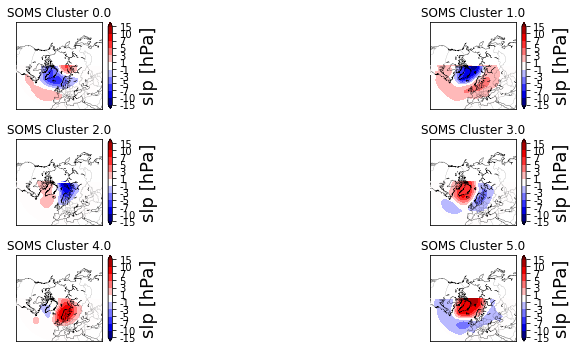

Dunn Index: 0.05327718763400674


In [12]:

LR=np.array([0.07])
SIGMA=np.array([0.7])
THRESHOLD=1e-7
NUM_ITER=np.array([10000])
dunn=np.zeros(len(SIGMA))
silhouette=np.zeros(len(SIGMA))
AREA="ATLANTIC"
path = r"N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/"
path_file = r"slp_hpa_ERA5_1985-2014.N_mjjaso_atrbg_aacrm21_remapbnds.nc"

#
nc = NetCDFFile(path+path_file)
data_normalized, lon, lat, var = einlesen(AREA, nc)


bmus,cluster_centers = clustering(LR,SIGMA,THRESHOLD,NUM_ITER,AREA,data_normalized, lon, lat,var,3,2,n_init=100,PLOTTEN=True)
#print(f"Der Silhouette score ist: {silhouette}")
#print(f"Der Dunn-score ist: {dunn}")
# plt.plot(SIGMA,dunn)
# plt.savefig(f"N:/atm_glomod/user/jomuel001/Dokumente/Presentations/ARBEIT/Dunn_score.png")
# plt.show()
# plt.plot(SIGMA,silhouette)
# plt.savefig(f"N:/atm_glomod/user/jomuel001/Dokumente/Presentations/ARBEIT/Silhouette_score.png")
# plt.show()
# Assuming 'bmus' is your list of BMUs
#Kmeans(bmus)

In [ ]:
#len(center[0][1])

In [9]:
def distance(center,array):
    result = np.zeros(len(array))
    for i in range(len(array)):
        result[i]=np.linalg.norm(array[i]-center)
    return result
def projecting(center, daten_CMIP):
    #center sind (2,2,8640) shape zB, daten CMIP (5520,8640)
    center_1=center[0][0]
    center_2=center[0][1]
    center_3=center[0][2]
    center_4=center[0][3]
    center_5=center[0][4]

    for i in range(daten_CMIP.shape[0]):
        distances=np.array([[distance(center_1,daten_CMIP[i])],[distance(center_2,daten_CMIP[i])],[distance(center_3,daten_CMIP[i])],[distance(center_4,daten_CMIP[i])],[distance(center_5,daten_CMIP[i])]])
        minimum_index = np.argmin(distances)
        write_array=np.array([i,minimum_index+1])
        print(write_array)

In [10]:
AREA="-90_90_89.7849_29.0866"

seas=[31,28,31,30,31,30,31,31,30,31,30,31]
months=np.array([5,6,7,8,9,10])#np.arange(1,9,1)
saison="mjjaso"
mode='future'
scenario=""
if mode=='future':
    years=np.arange(2070,2100,1)
else:y
    
    years=np.arange(1985,2014,1) #verändern
centers = np.loadtxt(r'N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_5cluster_10PC_center.unnorm',usecols=range(1, 11), delimiter=' ',skiprows=0)
print(centers)
if scenario=="_ssp2":
   # models =["KACE-1-0-G", "MIROC-ES2L", "NESM3", "NorESM2-LM"]
    models= ["ACCESS-CM2", "ACCESS-ESM1", "CESM2-WACCM", "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", #ssp5,2
         "GFDL-CM4", "GFDL-ESM4","HadGEM3-GC31-LL", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC6", 
         "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorESM2-MM", "UKESM1-0-LL"]
elif scenario=="":
    #models=["KACE-1-0-G", "MIROC-ES2L", "NESM3", "NorESM2-LM"]
    models =["ACCESS-CM2", "ACCESS-ESM1", "CESM2-WACCM", "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", #ssp5,2
         "GFDL-CM4", "GFDL-ESM4","HadGEM3-GC31-LL", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC6", 
         "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorESM2-MM", "UKESM1-0-LL"]
elif scenario=="_ssp1":
    #models= ["KACE-1-0-G", "MIROC-ES2L", "NESM3", "NorESM2-LM"]
    models=["ACCESS-CM2", "ACCESS-ESM1", "CESM2-WACCM", "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", #ssp1
          "GFDL-ESM4","HadGEM3-GC31-LL", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC6", 
         "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorESM2-MM", "UKESM1-0-LL"]
elif scenario=="_ssp3":
    #models = ["KACE-1-0-G", "MIROC-ES2L", "NorESM2-LM"]
    ["ACCESS-CM2", "ACCESS-ESM1", "CESM2-WACCM", "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1",  #ssp3
          "GFDL-ESM4", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC6",  "MPI-ESM1-2-LR", "MRI-ESM2-0", "UKESM1-0-LL"]
elif scenario=="hist":
    models = ["ACCESS-CM2", "ACCESS-ESM1", "CESM2-WACCM", "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", #ssp5,2
         "GFDL-CM4", "GFDL-ESM4","HadGEM3-GC31-LL", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC6", 
         "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorESM2-MM", "UKESM1-0-LL"]
    scenario=""
#
    #models=["KACE-1-0-G", "MIROC-ES2L", "NESM3", "NorESM2-LM"]
if mode=='future':
    year_zusatz = "2070-2099.N_"+saison+"_atrbg_aacHrm21"
    print("future")
else:
    year_zusatz = "1985-2014.N_"+saison+"_atrbg_aacrm21"
def distance(center,array):
    result = np.zeros(len(array))
    for i in range(len(array)):
        result[i]=np.linalg.norm(array[i]-center)
    return result
def scientific_to_standard(num_string):
    return float(num_string.replace('E+', '1e'))

for model in models:
    #pc = pd.read_csv(,sep="\t",header=None)
    with open(r'N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/EOF/PCslp_hpa'+scenario+'_'+model+'_'+year_zusatz+r'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_cos_cov_svd_unnorm', 'r') as file:
        contents = file.read().split()
        arr =np.array([float(item) for item in contents])
        pc = arr.reshape((-1, 10))
    data = {'dist_cl1': distance(centers[0],pc),
        'dist_cl2': distance(centers[1],pc),
        'dist_cl3': distance(centers[2],pc),
        'dist_cl4': distance(centers[3],pc)},#
        'dist_cl5': distance(centers[4],pc),
        #'dist_cl6': distance(centers[5],pc)}
    print(np.shape(data['dist_cl1']))
    tag=0
    tage_1=[]
    tage_2=[]
    tage_3=[]
    tage_4=[]
    tage_5=[]
    #tage_6=[]
    #null=np.array([0])
    #np.savetxt(r'N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_6tabcluster_10tabPC_dates', null)
    # Ensure the directory structure exists, creating any missing directories
    #os.makedirs(file_path, exist_ok=True)
    with open(r'N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_5tabcluster_10tabPC_dates', 'w') as f:
        try:
            for year in years:
                for month in months: 
                    for day in range(1,seas[month-1]+1):
                        try:
                            distances_tag = np.array([data['dist_cl1'][tag], data['dist_cl2'][tag], data['dist_cl3'][tag], data['dist_cl4'][tag], data['dist_cl5'][tag]])#, data['dist_cl6'][tag]])
                            minimum_index = np.argmin(distances_tag)
                            #print(distances_tag)
                        except:
                            minimum_index = -1
                        write_array = np.array([year, month, day, minimum_index+1,0,0])
                        f.write(' '.join(map(str, write_array)))
                        f.write('\n')
                        if minimum_index+1==1:
                            tage_1.append(int(tag))
                        elif minimum_index+1==2:
                            tage_2.append(int(tag))
                        elif minimum_index+1==3:
                            tage_3.append(int(tag))
                        elif minimum_index+1==4:
                            tage_4.append(int(tag))
                        elif minimum_index+1==5: 
                            tage_5.append(int(tag))
                        #elif minimum_index+1==6: 
                        #    tage_6.append(int(tag))
                        else:
                            continue
                        tag+=1
        except:
            print("fehlen bei "+model+" 120 tage")
    tage_1=np.array(tage_1)
    tage_2=np.array(tage_2)
    tage_3=np.array(tage_3)
    tage_4=np.array(tage_4)
    tage_5=np.array(tage_5)
    #tage_6=np.array(tage_6)
    np.savetxt('N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_5cluster_10PC_cl1_dates', tage_1,fmt='%d')
    np.savetxt('N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_5cluster_10PC_cl2_dates', tage_2,fmt='%d')
    np.savetxt('N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_5cluster_10PC_cl3_dates', tage_3,fmt='%d')
    np.savetxt('N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_5cluster_10PC_cl4_dates', tage_4,fmt='%d')
    np.savetxt('N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_5cluster_10PC_cl5_dates', tage_5,fmt='%d')
    #np.savetxt('N:/atm_glomod/user/jomuel001/CMIP6_models/'+model+r'/AREA.'+AREA+r'/CLUSTER/KMEANSslp_hpa'+scenario+'_'+model+'_'+year_zusatz+'_remapbnds_proj_on_EOF_ERA51985-2014slp_hpa_ERA5_1985-2014_'+saison+'_atrbg_aacrm21_remapbnds_unnorm_projectedpattern_6cluster_10PC_cl6_dates', tage_6,fmt='%d')   


future
einlesen beginnt


<ipython-input-2-febc21c1b4aa>:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = nc.variables['lat'][:54]
<ipython-input-2-febc21c1b4aa>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = nc.variables['lon'][:]
<ipython-input-2-febc21c1b4aa>:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this w

einlesen fertig
(5520, 8640)
[   0 9481]
[    1 14648]
[    2 14185]
[    3 11877]
[    4 11121]
[    5 15397]
[    6 12336]
[    7 15274]
[   8 9005]
[    9 16383]
[   10 17045]
[   11 16151]
[   12 14455]
[  13 9347]
[   14 12487]
[   15 15995]
[   16 17001]
[   17 12408]
[   18 10508]
[  19 9620]
[   20 13099]
[   21 15129]
[   22 11914]
[   23 14754]
[   24 14476]
[   25 11109]
[   26 16021]
[   27 17204]
[   28 11214]
[   29 15621]
[  30 9918]
[   31 15684]
[   32 10655]
[   33 13786]
[   34 10046]
[  35 9410]
[   36 16805]
[   37 15527]
[   38 10474]
[   39 16276]
[   40 10654]
[   41 16955]
[   42 16973]
[   43 15875]
[   44 14172]
[   45 17024]
[   46 16903]
[   47 12628]
[   48 12059]
[   49 16230]
[   50 16797]
[   51 16952]
[   52 12268]
[   53 15570]
[   54 10320]
[   55 16519]
[   56 13445]
[   57 10899]
[   58 15584]
[   59 10679]
[  60 9041]
[   61 14865]
[   62 10474]
[   63 17259]
[   64 15485]
[   65 16636]
[   66 16629]
[   67 15499]
[   68 13931]
[  69 9436]
[   70 

[  592 13481]
[  593 11979]
[  594 15127]
[  595 16455]
[  596 11022]
[  597 16407]
[ 598 9763]
[ 599 9350]
[  600 11353]
[  601 16796]
[  602 15590]
[ 603 9853]
[  604 11631]
[  605 15508]
[  606 13827]
[  607 10762]
[  608 16099]
[  609 16999]
[  610 16511]
[  611 13809]
[  612 14514]
[  613 13625]
[  614 13599]
[  615 13296]
[  616 10589]
[  617 13284]
[  618 10504]
[  619 15605]
[  620 16828]
[  621 15473]
[  622 16168]
[  623 15057]
[  624 16205]
[  625 12870]
[  626 10487]
[ 627 9222]
[  628 14679]
[  629 10545]
[  630 14917]
[  631 12362]
[ 632 9965]
[  633 12405]
[  634 16709]
[  635 13519]
[ 636 9552]
[  637 15979]
[ 638 9197]
[  639 16998]
[  640 11036]
[  641 13922]
[  642 13981]
[  643 15637]
[  644 11930]
[  645 13047]
[  646 12113]
[  647 16795]
[ 648 8982]
[  649 12159]
[  650 16817]
[  651 15384]
[  652 15747]
[  653 13030]
[  654 14017]
[  655 12571]
[  656 12195]
[  657 16201]
[  658 15105]
[  659 15216]
[  660 16513]
[  661 13067]
[  662 16457]
[  663 13707]
[  664 1

[ 1186 10747]
[ 1187 16546]
[ 1188 15642]
[ 1189 17173]
[ 1190 12863]
[ 1191 16641]
[ 1192 10753]
[ 1193 11230]
[1194 9236]
[ 1195 16984]
[ 1196 11246]
[ 1197 15907]
[ 1198 14612]
[ 1199 13683]
[ 1200 14619]
[ 1201 15023]
[ 1202 15055]
[1203 9123]
[ 1204 13914]
[ 1205 17002]
[ 1206 14271]
[ 1207 16715]
[ 1208 14416]
[ 1209 16616]
[ 1210 13448]
[ 1211 16435]
[ 1212 14516]
[ 1213 16612]
[ 1214 17123]
[ 1215 11358]
[ 1216 16969]
[ 1217 10754]
[ 1218 16214]
[ 1219 14678]
[ 1220 14273]
[ 1221 12732]
[ 1222 15209]
[ 1223 15482]
[ 1224 16946]
[ 1225 16367]
[ 1226 15264]
[ 1227 14679]
[ 1228 12827]
[ 1229 16382]
[1230 9209]
[ 1231 16545]
[ 1232 16720]
[ 1233 11445]
[ 1234 17119]
[ 1235 16400]
[ 1236 10492]
[ 1237 16803]
[ 1238 12652]
[ 1239 14689]
[ 1240 14217]
[ 1241 15105]
[ 1242 11931]
[ 1243 10031]
[ 1244 12110]
[ 1245 16332]
[ 1246 17077]
[ 1247 16935]
[ 1248 14466]
[ 1249 10393]
[ 1250 11139]
[ 1251 13889]
[1252 9628]
[ 1253 16530]
[ 1254 14210]
[1255 9072]
[ 1256 12545]
[1257 9842]
[ 12

[ 1781 16223]
[ 1782 12325]
[ 1783 12872]
[ 1784 16386]
[ 1785 17222]
[1786 9903]
[ 1787 17153]
[1788 9983]
[ 1789 11416]
[ 1790 16048]
[ 1791 15177]
[ 1792 15105]
[ 1793 14949]
[ 1794 13192]
[ 1795 16231]
[ 1796 16167]
[ 1797 17208]
[ 1798 13004]
[ 1799 10846]
[ 1800 16514]
[ 1801 12381]
[ 1802 11797]
[ 1803 16524]
[ 1804 16439]
[ 1805 17124]
[ 1806 17004]
[ 1807 14398]
[ 1808 15612]
[ 1809 14016]
[ 1810 12007]
[ 1811 13472]
[ 1812 16334]
[ 1813 13436]
[ 1814 14578]
[ 1815 15547]
[ 1816 10884]
[ 1817 16005]
[ 1818 17022]
[ 1819 14033]
[ 1820 11040]
[ 1821 12021]
[ 1822 16476]
[ 1823 11867]
[1824 8701]
[ 1825 13718]
[ 1826 11073]
[ 1827 13352]
[ 1828 15747]
[ 1829 15535]
[ 1830 11669]
[1831 8808]
[ 1832 15056]
[ 1833 16665]
[ 1834 10567]
[ 1835 12515]
[1836 8694]
[ 1837 12623]
[ 1838 16483]
[ 1839 16949]
[ 1840 17269]
[1841 9741]
[ 1842 10860]
[ 1843 16681]
[ 1844 12174]
[ 1845 16485]
[ 1846 16934]
[ 1847 11881]
[ 1848 15996]
[1849 9914]
[ 1850 13393]
[ 1851 16087]
[ 1852 15005]
[ 1853

[ 2377 16917]
[ 2378 16637]
[ 2379 16986]
[2380 9467]
[ 2381 14963]
[ 2382 15243]
[2383 9304]
[ 2384 10647]
[ 2385 13095]
[ 2386 15474]
[ 2387 15451]
[ 2388 11006]
[ 2389 16797]
[ 2390 11747]
[ 2391 16398]
[ 2392 16362]
[ 2393 12451]
[ 2394 14703]
[ 2395 16874]
[ 2396 14083]
[ 2397 14609]
[ 2398 17028]
[ 2399 10813]
[ 2400 17148]
[2401 8971]
[ 2402 17154]
[ 2403 15814]
[ 2404 14005]
[ 2405 15606]
[ 2406 16818]
[ 2407 17160]
[ 2408 11413]
[ 2409 11994]
[ 2410 15593]
[ 2411 16431]
[ 2412 10435]
[ 2413 14102]
[ 2414 15129]
[ 2415 12410]
[ 2416 14295]
[ 2417 12055]
[ 2418 14740]
[ 2419 10690]
[ 2420 16319]
[ 2421 16957]
[ 2422 12917]
[ 2423 16347]
[ 2424 17273]
[ 2425 14765]
[ 2426 16324]
[ 2427 12167]
[ 2428 12403]
[ 2429 17095]
[ 2430 16583]
[ 2431 15565]
[ 2432 12952]
[ 2433 12477]
[ 2434 14743]
[ 2435 16676]
[ 2436 12104]
[ 2437 16544]
[ 2438 14996]
[ 2439 16701]
[ 2440 16341]
[ 2441 15670]
[2442 8691]
[ 2443 13892]
[ 2444 13650]
[ 2445 10273]
[ 2446 12786]
[2447 9604]
[ 2448 12745]
[ 

[ 2970 10486]
[ 2971 14912]
[ 2972 15199]
[ 2973 15916]
[ 2974 12555]
[ 2975 10756]
[ 2976 13616]
[ 2977 15607]
[ 2978 10346]
[ 2979 10611]
[ 2980 16413]
[ 2981 16169]
[ 2982 16882]
[ 2983 10844]
[ 2984 15909]
[ 2985 13346]
[2986 9393]
[ 2987 17219]
[ 2988 16074]
[ 2989 13850]
[ 2990 15560]
[ 2991 13475]
[ 2992 11470]
[ 2993 16944]
[ 2994 13232]
[ 2995 14291]
[ 2996 16084]
[ 2997 16232]
[ 2998 15082]
[ 2999 16566]
[ 3000 16392]
[ 3001 14592]
[ 3002 16964]
[ 3003 14163]
[ 3004 15925]
[ 3005 14797]
[ 3006 16954]
[3007 9406]
[3008 9077]
[ 3009 15004]
[ 3010 12021]
[ 3011 10424]
[ 3012 16731]
[ 3013 11385]
[ 3014 16759]
[3015 8684]
[ 3016 14811]
[3017 9774]
[ 3018 11199]
[ 3019 10411]
[ 3020 14767]
[ 3021 14792]
[ 3022 10556]
[ 3023 11386]
[ 3024 13542]
[ 3025 16766]
[ 3026 16572]
[3027 8942]
[ 3028 14092]
[ 3029 17114]
[3030 8850]
[ 3031 13888]
[ 3032 15467]
[ 3033 12951]
[ 3034 17102]
[ 3035 12941]
[ 3036 11159]
[3037 9443]
[3038 9616]
[ 3039 16198]
[ 3040 16196]
[ 3041 15172]
[ 3042 154

[ 3562 11833]
[ 3563 15155]
[ 3564 11191]
[ 3565 10060]
[ 3566 16170]
[ 3567 16640]
[ 3568 13949]
[ 3569 13896]
[ 3570 12338]
[3571 9817]
[ 3572 14302]
[3573 9807]
[ 3574 14796]
[ 3575 12214]
[ 3576 15394]
[ 3577 15692]
[ 3578 15997]
[ 3579 10538]
[3580 8747]
[ 3581 15107]
[ 3582 15614]
[ 3583 16319]
[ 3584 10587]
[ 3585 14084]
[ 3586 11276]
[ 3587 15866]
[ 3588 16300]
[ 3589 16000]
[ 3590 17119]
[ 3591 17079]
[ 3592 10816]
[ 3593 11939]
[ 3594 11559]
[ 3595 17084]
[ 3596 15498]
[3597 8791]
[ 3598 12541]
[ 3599 14802]
[ 3600 15190]
[ 3601 16413]
[ 3602 11677]
[3603 9706]
[ 3604 15667]
[ 3605 15198]
[ 3606 16094]
[ 3607 13332]
[ 3608 10246]
[ 3609 14088]
[ 3610 17035]
[ 3611 12531]
[ 3612 16717]
[ 3613 12307]
[3614 9372]
[ 3615 14167]
[3616 8819]
[ 3617 12604]
[ 3618 15379]
[ 3619 15597]
[ 3620 13022]
[ 3621 15537]
[3622 9194]
[ 3623 10707]
[ 3624 11929]
[ 3625 10007]
[ 3626 15046]
[ 3627 14820]
[ 3628 16964]
[ 3629 16878]
[ 3630 13082]
[ 3631 16973]
[ 3632 13285]
[ 3633 15237]
[3634 93

[ 4157 11789]
[ 4158 11976]
[ 4159 15387]
[ 4160 12791]
[ 4161 17001]
[ 4162 14902]
[ 4163 15765]
[ 4164 14350]
[4165 9515]
[ 4166 13892]
[ 4167 17111]
[ 4168 15199]
[ 4169 16724]
[ 4170 16013]
[ 4171 15998]
[ 4172 12323]
[ 4173 16494]
[ 4174 10561]
[ 4175 15216]
[ 4176 15285]
[ 4177 10875]
[ 4178 15474]
[ 4179 14865]
[ 4180 13302]
[ 4181 15329]
[ 4182 10534]
[ 4183 16735]
[ 4184 14151]
[4185 9600]
[ 4186 11005]
[ 4187 10481]
[ 4188 17200]
[ 4189 16336]
[ 4190 11419]
[4191 9310]
[ 4192 14170]
[ 4193 10291]
[ 4194 16694]
[ 4195 16539]
[ 4196 16766]
[ 4197 16617]
[ 4198 15828]
[ 4199 12184]
[ 4200 10408]
[ 4201 16625]
[ 4202 15067]
[ 4203 14960]
[ 4204 16559]
[ 4205 16225]
[ 4206 13231]
[ 4207 17165]
[ 4208 15209]
[ 4209 14961]
[ 4210 15814]
[ 4211 16868]
[ 4212 16687]
[ 4213 16379]
[4214 9787]
[ 4215 13864]
[ 4216 17048]
[ 4217 17015]
[ 4218 16730]
[ 4219 15058]
[ 4220 14026]
[ 4221 11039]
[ 4222 15223]
[ 4223 15427]
[ 4224 16504]
[ 4225 16255]
[ 4226 14826]
[ 4227 15042]
[ 4228 17027]


[ 4752 17108]
[ 4753 16225]
[ 4754 16019]
[ 4755 14563]
[ 4756 15990]
[ 4757 11261]
[ 4758 16868]
[ 4759 14296]
[ 4760 14450]
[ 4761 11833]
[ 4762 16035]
[ 4763 15163]
[ 4764 17169]
[ 4765 13964]
[ 4766 16691]
[ 4767 15539]
[ 4768 12959]
[ 4769 16647]
[ 4770 17171]
[ 4771 15883]
[ 4772 10660]
[ 4773 17246]
[ 4774 10679]
[ 4775 10970]
[ 4776 14021]
[ 4777 16148]
[ 4778 15558]
[ 4779 10527]
[ 4780 12761]
[ 4781 13467]
[ 4782 16093]
[ 4783 15067]
[ 4784 10416]
[ 4785 11501]
[ 4786 15446]
[ 4787 13785]
[4788 9264]
[ 4789 12151]
[ 4790 10675]
[ 4791 13794]
[ 4792 12494]
[ 4793 16728]
[ 4794 15623]
[ 4795 12677]
[ 4796 16544]
[ 4797 16678]
[ 4798 13490]
[ 4799 14173]
[ 4800 12544]
[ 4801 11585]
[ 4802 13117]
[ 4803 14758]
[ 4804 12520]
[4805 9611]
[ 4806 11740]
[ 4807 16288]
[ 4808 16660]
[ 4809 14913]
[ 4810 11108]
[4811 9205]
[ 4812 12403]
[ 4813 17007]
[ 4814 14944]
[ 4815 15614]
[ 4816 15315]
[ 4817 13239]
[ 4818 14877]
[ 4819 13634]
[ 4820 11664]
[ 4821 10693]
[ 4822 16905]
[ 4823 16350

[5344 8970]
[ 5345 10285]
[ 5346 15762]
[ 5347 15798]
[ 5348 10974]
[ 5349 16267]
[ 5350 16396]
[ 5351 12717]
[ 5352 16056]
[ 5353 13489]
[ 5354 16523]
[ 5355 16873]
[ 5356 13863]
[ 5357 13197]
[ 5358 14604]
[ 5359 15056]
[ 5360 14536]
[ 5361 14605]
[ 5362 14616]
[ 5363 15885]
[ 5364 10422]
[ 5365 10961]
[ 5366 16526]
[ 5367 11211]
[ 5368 12213]
[ 5369 11542]
[ 5370 13853]
[ 5371 11323]
[ 5372 12531]
[ 5373 10732]
[ 5374 11847]
[ 5375 16967]
[ 5376 12068]
[ 5377 15930]
[ 5378 15866]
[ 5379 15965]
[ 5380 15881]
[5381 9957]
[ 5382 13188]
[ 5383 12816]
[ 5384 15821]
[ 5385 13535]
[ 5386 14718]
[ 5387 15142]
[ 5388 13388]
[ 5389 16688]
[ 5390 15970]
[ 5391 16380]
[ 5392 12611]
[ 5393 11957]
[ 5394 11774]
[ 5395 15019]
[ 5396 16211]
[ 5397 12998]
[ 5398 12990]
[ 5399 15863]
[ 5400 10884]
[ 5401 13602]
[ 5402 17017]
[ 5403 13034]
[ 5404 12024]
[ 5405 13441]
[ 5406 16670]
[ 5407 16156]
[ 5408 16635]
[ 5409 11413]
[ 5410 12304]
[ 5411 16938]
[ 5412 17124]
[ 5413 14226]
[ 5414 16330]
[ 5415 100

<ipython-input-2-febc21c1b4aa>:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = nc.variables['lat'][:54]
<ipython-input-2-febc21c1b4aa>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = nc.variables['lon'][:]
<ipython-input-2-febc21c1b4aa>:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this w

einlesen fertig
(5520, 8640)
[    0 13656]
[   1 9711]
[    2 13934]
[    3 11941]
[    4 14852]
[    5 12979]
[    6 17076]
[    7 13337]
[    8 12244]
[    9 11755]
[   10 17123]
[   11 16417]
[   12 15136]
[   13 10866]
[   14 13878]
[   15 10164]
[   16 10301]
[   17 11276]
[   18 11028]
[   19 10040]
[   20 11179]
[   21 17172]
[   22 14455]
[   23 14388]
[   24 16217]
[   25 14370]
[   26 13003]
[   27 13047]
[   28 13124]
[   29 14840]
[   30 17183]
[   31 13854]
[   32 10401]
[  33 9063]
[  34 9155]
[   35 17070]
[   36 16845]
[  37 8989]
[   38 14839]
[   39 14926]
[   40 13245]
[   41 12323]
[   42 13566]
[   43 13825]
[  44 9206]
[   45 13533]
[  46 9979]
[   47 13248]
[   48 14421]
[   49 14994]
[   50 12494]
[   51 16886]
[   52 16721]
[   53 10483]
[   54 10046]
[  55 9250]
[   56 16145]
[   57 15132]
[  58 9845]
[   59 16605]
[   60 10491]
[   61 14513]
[   62 15627]
[   63 15679]
[   64 16452]
[   65 10762]
[  66 9503]
[   67 14817]
[   68 12394]
[   69 15481]
[   70 15

[  592 14324]
[  593 15458]
[  594 14022]
[  595 14263]
[  596 10001]
[  597 17039]
[  598 13197]
[  599 10838]
[  600 16880]
[  601 13950]
[  602 16884]
[  603 15100]
[  604 13281]
[  605 13714]
[  606 13753]
[  607 11974]
[  608 10035]
[  609 11437]
[  610 13491]
[  611 13337]
[  612 14425]
[  613 14521]
[  614 12669]
[  615 11610]
[  616 11504]
[  617 13428]
[  618 12218]
[  619 10865]
[  620 11467]
[ 621 9638]
[  622 13876]
[ 623 8861]
[  624 14600]
[  625 13844]
[  626 11340]
[ 627 8891]
[  628 10280]
[  629 11043]
[ 630 8957]
[  631 12668]
[  632 10593]
[  633 12071]
[  634 14172]
[  635 15780]
[  636 10511]
[  637 13920]
[  638 15977]
[  639 11779]
[  640 14488]
[  641 10243]
[ 642 9093]
[ 643 9626]
[  644 11807]
[  645 15292]
[  646 15173]
[  647 14189]
[  648 14965]
[  649 13936]
[  650 15699]
[  651 10404]
[  652 15928]
[  653 13308]
[  654 12278]
[  655 14574]
[  656 12695]
[ 657 9444]
[  658 15317]
[  659 16270]
[  660 14706]
[ 661 8917]
[  662 12597]
[  663 16871]
[  664 1

[ 1187 12699]
[ 1188 13680]
[ 1189 17061]
[ 1190 13497]
[ 1191 16598]
[ 1192 14965]
[ 1193 13726]
[ 1194 12774]
[ 1195 11137]
[ 1196 15329]
[ 1197 14032]
[ 1198 17217]
[ 1199 16892]
[ 1200 14224]
[ 1201 12996]
[ 1202 17214]
[ 1203 13360]
[ 1204 13053]
[ 1205 16575]
[ 1206 11197]
[ 1207 11979]
[ 1208 10648]
[ 1209 13939]
[ 1210 10302]
[ 1211 10292]
[ 1212 12492]
[ 1213 10025]
[ 1214 16405]
[ 1215 13361]
[ 1216 11137]
[ 1217 13886]
[ 1218 11573]
[ 1219 12437]
[ 1220 16866]
[ 1221 13721]
[ 1222 10079]
[ 1223 13095]
[ 1224 11675]
[ 1225 13199]
[ 1226 14302]
[ 1227 11536]
[ 1228 14177]
[ 1229 15328]
[ 1230 14648]
[ 1231 11121]
[ 1232 11534]
[ 1233 11281]
[ 1234 14599]
[1235 8982]
[1236 9243]
[ 1237 15125]
[ 1238 15044]
[ 1239 15549]
[ 1240 11177]
[1241 9208]
[ 1242 16912]
[ 1243 10151]
[ 1244 16005]
[ 1245 16649]
[ 1246 15633]
[ 1247 10002]
[ 1248 15691]
[ 1249 14961]
[ 1250 15432]
[ 1251 15111]
[1252 9254]
[1253 9856]
[ 1254 14551]
[ 1255 14873]
[ 1256 14296]
[ 1257 11527]
[ 1258 11035]
[1

[ 1784 12529]
[ 1785 11593]
[ 1786 15483]
[ 1787 14958]
[ 1788 10734]
[ 1789 10649]
[ 1790 11474]
[ 1791 10458]
[1792 9932]
[ 1793 11394]
[ 1794 13939]
[ 1795 13979]
[ 1796 14551]
[ 1797 14095]
[ 1798 14301]
[ 1799 15805]
[ 1800 15493]
[ 1801 14764]
[ 1802 14236]
[ 1803 15561]
[ 1804 12031]
[ 1805 15441]
[ 1806 14147]
[ 1807 11169]
[ 1808 11181]
[ 1809 16269]
[ 1810 12674]
[ 1811 13722]
[ 1812 15537]
[ 1813 14181]
[ 1814 14431]
[ 1815 15930]
[ 1816 14429]
[ 1817 12672]
[ 1818 15088]
[ 1819 10312]
[ 1820 15317]
[1821 9735]
[ 1822 12500]
[1823 9565]
[ 1824 12270]
[ 1825 12553]
[ 1826 11529]
[ 1827 10961]
[1828 9576]
[ 1829 14137]
[ 1830 15199]
[ 1831 14229]
[ 1832 15072]
[ 1833 16115]
[ 1834 10144]
[ 1835 14989]
[ 1836 12769]
[ 1837 10607]
[ 1838 11951]
[ 1839 10358]
[ 1840 17078]
[1841 9209]
[1842 9987]
[ 1843 11999]
[ 1844 17223]
[ 1845 12922]
[ 1846 10490]
[ 1847 12987]
[ 1848 13816]
[ 1849 17186]
[1850 9539]
[1851 8913]
[ 1852 17092]
[ 1853 16404]
[ 1854 15870]
[ 1855 17018]
[ 1856 1

[ 2378 15035]
[ 2379 17266]
[2380 9480]
[ 2381 12490]
[ 2382 15767]
[ 2383 15613]
[ 2384 12372]
[ 2385 10633]
[ 2386 16027]
[ 2387 12738]
[ 2388 15069]
[ 2389 14689]
[ 2390 15792]
[ 2391 11622]
[ 2392 15090]
[ 2393 15511]
[ 2394 15831]
[ 2395 14400]
[2396 9500]
[ 2397 11567]
[ 2398 16494]
[ 2399 12043]
[ 2400 14040]
[ 2401 11127]
[ 2402 11036]
[2403 9466]
[ 2404 16321]
[ 2405 10495]
[ 2406 14274]
[ 2407 16891]
[ 2408 10481]
[ 2409 10439]
[ 2410 14367]
[ 2411 16002]
[ 2412 16580]
[ 2413 12633]
[ 2414 11395]
[ 2415 15014]
[ 2416 14417]
[ 2417 15703]
[ 2418 15959]
[ 2419 14718]
[ 2420 16959]
[ 2421 15314]
[ 2422 16896]
[ 2423 14820]
[ 2424 15999]
[ 2425 17225]
[ 2426 12703]
[ 2427 13011]
[ 2428 17152]
[ 2429 16407]
[ 2430 14035]
[ 2431 11702]
[ 2432 14081]
[ 2433 11914]
[ 2434 15830]
[ 2435 12211]
[ 2436 11495]
[ 2437 15654]
[ 2438 11158]
[ 2439 12858]
[2440 9688]
[ 2441 12182]
[ 2442 15360]
[ 2443 16782]
[2444 9039]
[ 2445 16608]
[ 2446 15513]
[ 2447 15656]
[2448 9683]
[ 2449 15820]
[ 24

KeyboardInterrupt: 

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [8]:
np.array([1,2,3,4,5])

array([1, 2, 3, 4, 5])

In [3]:
from sklearn.cluster import KMeans
from collections import Counter

def Kmeans(bmus):
    # Assuming 'bmus' is your list of BMUs
    num_clusters = 5  # Number of clusters

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(bmus)

    # Get the cluster labels assigned by K-means
    kmeans_labels = kmeans.labels_
    np.savetxt(path+r"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSKMEANSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_5tabcluster_10tabPC_dates.txt", kmeans_labels)
    datesfile=path+r"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSKMEANSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_5tabcluster_10tabPC_dates.txt"
    FONTSIZE = 18
    lons,lats = np.meshgrid(lon,lat)
    dates=np.loadtxt(datesfile)
    cluster=dates[:5520] # weil auch zukunft in dem ding drin ist
    cluster_numbers = [0.0, 1.0, 2.0, 3.0, 4.0]
    iteration=0
    fig, axes = plt.subplots(1, len(cluster_numbers), figsize=(16, 4))  # Adjust figsize as needed
    # Assuming kmeans_labels contains the cluster assignments
    cluster_counts = Counter(kmeans_labels)

    # Print the frequency of occurrence for each cluster
    for cluster_num, count in cluster_counts.items():
        print(f'Cluster {cluster_num}: Frequency = {count/5520}')
    # Loop through the cluster numbers
    for i, cluster_number in enumerate(cluster_numbers):
        map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        x,y = map(lons,lats)
        nc = NetCDFFile(path + path_file)
        # Create a filter for the current cluster number
        cluster_filter = [x == cluster_number for x in cluster]
        FONTSIZE = 18
        # Calculate the mean for the current cluster
        soms = np.mean(var[cluster_filter, :, :], axis=0)

        # Define levels and boundaries
        levels = np.array([-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])
        boundaries = np.linspace(-0, 0.1, 13)

        # Create the contour plot in the corresponding subplot
        variable = map.contourf(x, y, soms[:54, :], cmap="seismic", levels=levels, zorder=5, extend='both', ax=axes[i])
        cb = map.colorbar(variable, ax=axes[i],fraction=0.05, pad=0.08,
                          ticks=[-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])

        # Customize the colorbar
        for t in cb.ax.get_xticklabels():
            t.set_fontsize(18)
        cb.set_ticklabels(["-15", "-10", "-7", "-5", "-3", "-1", "1", "3", "5", "7", "10", "15"])

        # Customize the plot title and labels
        axes[i].set_title(f'KMEANS Cluster {cluster_number}')
        cb.set_label('slp [hPa]', fontsize=18)

        # Draw coastlines and countries
        map.drawcoastlines(linewidth=0.3, zorder=6, ax=axes[i])
        map.drawcountries(linewidth=0.1, zorder=7, ax=axes[i])

    # Adjust spacing between subplots
    plt.tight_layout()
    # Save the figure

    # Save the figure for the current cluster
    plt.savefig(f'N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/AREA.-90_90_89.7849_29.0866/CLUSTER/PLOTS/SOMSKMEANS_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remabbnds_unnorm_{len(cluster_numbers)}cluster_10PC_{LR}LR_{SIGMA}Sigma.png', dpi=300)
